In [1]:
pip install simpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


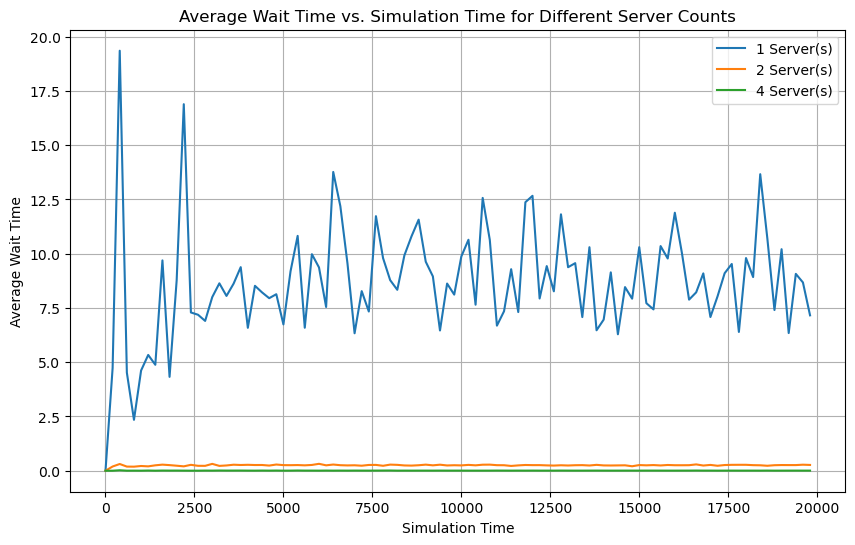

In [2]:
import simpy
import random
import statistics

# Parameters
λ = 0.9  # Arrival rate
μ = 1   # Service rate of each server
servers = [1, 2, 4]  # Number of servers to simulate
sim_time = 10000  # Simulation time

def customer(env, name, counter):
    """Customer process. Each customer arrives, waits, and is then served."""
    arrival_time = env.now
    with counter.request() as req:
        yield req
        wait = env.now - arrival_time
        wait_times.append(wait)
        service_time = random.expovariate(μ)
        yield env.timeout(service_time)

def setup(env, n):
    """Sets up the simulation environment with n servers."""
    counter = simpy.Resource(env, capacity=n)
    while True:
        yield env.timeout(random.expovariate(λ))
        env.process(customer(env, f'Customer{env.now}', counter))

average_wait_times = {n: [] for n in servers}  # Average waiting times for each number of servers
time_intervals = list(range(1, 20001, 200))  # Simulation time intervals from 1 to 20000, with a step of 200

for n in servers:
    random.seed(42)  # For reproducible results
    for sim_time in time_intervals:
        wait_times = []
        env = simpy.Environment()
        env.process(setup(env, n))
        env.run(until=sim_time)
        if wait_times:
            average_wait = statistics.mean(wait_times)
        else:
            average_wait = 0  # Set average wait to 0 if no data is available
        average_wait_times[n].append(average_wait)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for n in servers:
    plt.plot(time_intervals, average_wait_times[n], label=f'{n} Server(s)')

plt.xlabel('Simulation Time')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time vs. Simulation Time for Different Server Counts')
plt.legend()
plt.grid(True)
plt.show()

The statistical significance can be increased by running the simulation for a longer time or by executing multiple runs and averaging the results.
As for how the number of measurements required depends on ρ: When ρ is close to 1 (high system load), more measurements are needed to achieve high statistical significance due to increased variability in the system. Conversely, when ρ is lower, fewer measurements might suffice.

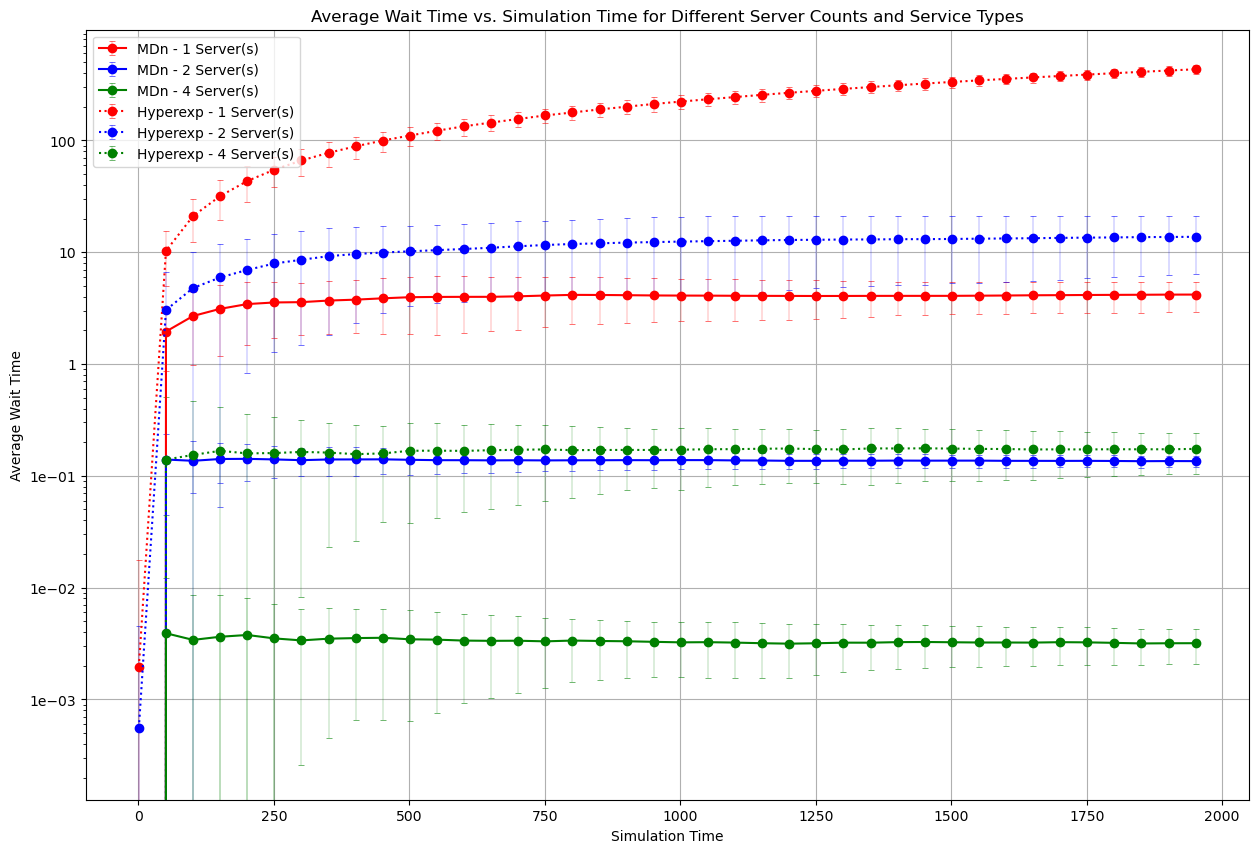

In [9]:
def multi_customer(env, name, counter, service_type):
    arrival_time = env.now
    with counter.request() as req:
        yield req
        wait = env.now - arrival_time
        wait_times.append(wait)

        if service_type == "MDn":
            # Deterministic service time
            service_time = 1 / μ
        elif service_type == "Hyperexp":
            # Hyperexponential service time
            if random.random() < 0.75:
                service_time = random.expovariate(1/1.0)  # 75% chance
            else:
                service_time = random.expovariate(1/5.0)  # 25% chance

        yield env.timeout(service_time)

def multi_setup(env, n, service_type):
    """Sets up the simulation environment with n servers and specified service type."""
    counter = simpy.Resource(env, capacity=n)
    while True:
        yield env.timeout(random.expovariate(λ))
        env.process(multi_customer(env, f'multi_customer{env.now}', counter, service_type))

λ = 0.9  # Arrival rate
μ = 1.0  # Service rate of each server
servers = [1, 2, 4]  # Number of servers to simulate

service_types = ["MDn", "Hyperexp"]
time_intervals = list(range(1, 2001, 50))  # Simulation time intervals

# Dictionary to hold average wait times for different service types and server counts
average_wait_times = {
    "MDn": {n: [] for n in servers},
    "Hyperexp": {n: [] for n in servers}
}

average_wait_times = {
    service_type: {
        n: {
            sim_time: {"averages": [], "std_devs": []}
            for sim_time in time_intervals
        } for n in servers
    } for service_type in service_types
}

num_runs = 100  # Number of times each simulation is repeated

for service_type in service_types:
    for n in servers:
        for sim_time in time_intervals:
            all_run_avg_waits = []

            for run in range(num_runs):
                # Reset random seed for each run for reproducibility
                random.seed(0 + run)

                # Run the simulation
                wait_times = []
                env = simpy.Environment()
                env.process(multi_setup(env, n, service_type))
                env.run(until=sim_time)

                # Collect the average wait time for this run
                average_wait = statistics.mean(wait_times) if wait_times else 0
                all_run_avg_waits.append(average_wait)

            # Calculate the mean and standard deviation of the 100 runs
            final_avg_wait = statistics.mean(all_run_avg_waits)
            final_std_dev = statistics.stdev(all_run_avg_waits)

            # Store the final average and standard deviation
            average_wait_times[service_type][n][sim_time]["average"] = final_avg_wait
            average_wait_times[service_type][n][sim_time]["std_dev"] = final_std_dev

from matplotlib.ticker import LogFormatter

# Define a color map for the server numbers
color_map = {1: 'red', 2: 'blue', 4: 'green'}

# Define line and marker styles for service types
line_styles = {'MDn': 'o-', 'Hyperexp': 'o:'}  # 'o-' for solid line with dots, 'o:' for dotted line with dots

plt.figure(figsize=(15, 10))

for service_type in service_types:
    for n in servers:
        # Extract means and standard deviations
        means = [average_wait_times[service_type][n][sim_time]["average"] for sim_time in time_intervals]
        std_devs = [average_wait_times[service_type][n][sim_time]["std_dev"] for sim_time in time_intervals]

        # Plot with customized styles
        plt.errorbar(time_intervals, means, yerr=std_devs, 
                     label=f'{service_type} - {n} Server(s)', 
                     fmt=line_styles[service_type],  # Line style based on service type
                     color=color_map[n],  # Color based on server number
                     ecolor=color_map[n],  # Error bar color
                     elinewidth=0.4,  # Error bar line width
                     capsize=2,  # Cap size
                     capthick=0.8)  # Cap thickness

plt.xlabel('Simulation Time')
plt.ylabel('Average Wait Time')
plt.yscale('log')
formatter = LogFormatter(10, labelOnlyBase=False)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('Average Wait Time vs. Simulation Time for Different Server Counts and Service Types')
plt.legend()
plt.grid(True)
plt.show()